# 02. Neural network classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as options).

## 1. Make classification data and get it ready

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

# make 1000 samples
n_samples = 1000

# create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [5]:
# Make a DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


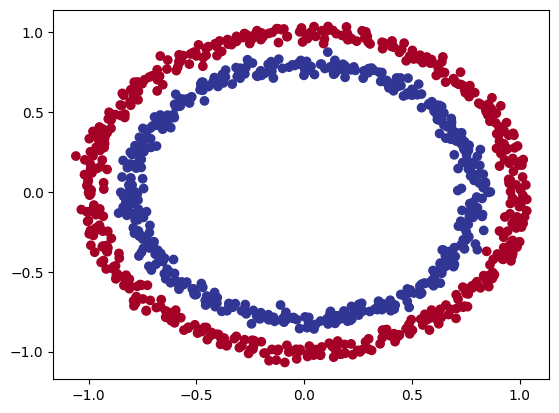

In [6]:
# Visualize, visualize, visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y,
            cmap=plt.cm.RdYlBu);

### 1.1 Check input and output shapes

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Value for 1 sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shape for 1 sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Value for 1 sample of X: [0.75424625 0.23148074] and the same for y: 1
Shape for 1 sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create training sets and testing sets

In [9]:
import torch
torch.__version__

'2.3.0'

In [10]:
type(X), type(y), X.dtype, y.dtype

(numpy.ndarray, numpy.ndarray, dtype('float64'), dtype('int64'))

In [11]:
# Turn data into tensors and float32
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [12]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [13]:
# Split data into training and test sets RANDOMLY
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2, # 20% will be test and 80% will be train
                                                   random_state=42)

In [14]:
len(X_train), len(y_train), len(X_test), len(y_test), n_samples

(800, 800, 200, 200, 1000)

## 2. Building a model

Build a model to classify our blue and red dots

To do so, we want to:
1. Set up device agnostic code so it runs on GPU
2. Construct a model (by subclassing `nn.Module`)
3. Define loss function and optimizer
4. Create a training and test loop

In [15]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

Let's create a model that:
1. Subclass `nn.Module`
2. Create 2 `nn.Linear()` layers that are capable of handling the shape of our data
3. Define a `forward()` method that outlines the forward pass for forward computation of the model
4. Instantiate an instance of our model class and send it to the target device

In [16]:
X_train.shape

torch.Size([800, 2])

In [17]:
# 1. Construct a model that subclass nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear() layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales it to 5 features
            # multiples of 8 are more efficient but we doing 5 to keep it simple
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 2 features from previous layer and outputs 1 feature (same shape as y)

    # 3. Defines a forward() method to make the forward pass
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

# 4. Instanciate an instance of our model class and send it to the device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
next(model_0.parameters()).device

device(type='mps', index=0)

In [19]:
# Let's replicate the model above with nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [20]:
model_0.state_dict # Weight and bias values created behind the scenes

<bound method Module.state_dict of Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)>

In [21]:
# Make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, shape: {X_test.shape}")
print(f"First 10 predictions: {torch.round(untrained_preds[:10])}")
print(f"First 10 labels: {y_test[:10]}")

Length of predictions: 200, shape: torch.Size([200, 1])
Length of test samples: 200, shape: torch.Size([200, 2])
First 10 predictions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='mps:0')
First 10 labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use? This is problem specific
* For regression: MAE or MSE
* For classification: binary cross entropy (BCE) or categorical cross entropy (cross entropy)

As a reminder, the loss function measures how wrong the model's predictions are.

And for optimizers, 2 of the most common and useful are:
* SGD
* Adam
(However, pytorch have many others)

In [22]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function built in

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [23]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

## 3. Train Model

Building a training loop:
1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits** 

We can convert these **logits** into **prediction probabilities** by passing them through some kind of activation function (eg. sigmoid for binary classification or softmax for multiclass classification)

Then, we can convert our model's **prediction probabilities** into prediction labels by either rounding them or taking the `argmax()`

In [24]:
# View the first 5 output of the forward pass on the forward pass
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0717],
        [-0.0155],
        [-0.0752],
        [-0.0712],
        [ 0.1527]], device='mps:0')

In [25]:
# Use the sigmoid activation function on our model logits
y_preds_probs = torch.sigmoid(y_logits)
y_preds_probs

tensor([[0.4821],
        [0.4961],
        [0.4812],
        [0.4822],
        [0.5381]], device='mps:0')

For our prediction probability values, we need to perform a range-style rounding on them:
* `y_preds_probs` >= 0.5, `y=1` (class 1)
* `y_preds_probs` < 0.5, `y=0` (class 2)

In [26]:
# Find the predicted labels
y_preds = torch.round(y_preds_probs)

# In full (logits -> preds_probs -> preds_labels)
y_preds_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_preds_labels.squeeze()))

# Get rid of extra dimension again
y_preds.squeeze()

tensor([True, True, True, True, True], device='mps:0')


tensor([0., 0., 0., 0., 1.], device='mps:0')

### 3.2 Building a training and testing loop

In [27]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Send the data to mps
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_0.train()
    
    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate the loss/accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss() expects raw logits as inputs
    acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Back propagation
    loss.backward()

    # 5. Gradient descent
    optimizer.step()

    ### Testing
    model_0.eval()

    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate the test loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss:.5f} | Train accuracy: {acc:.2f}% | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")

Epoch: 0 | Train loss: 0.69513 | Train accuracy: 50.00% | Test loss: 0.69576 | Test accuracy: 52.50%
Epoch: 100 | Train loss: 0.69383 | Train accuracy: 49.75% | Test loss: 0.69432 | Test accuracy: 51.50%
Epoch: 200 | Train loss: 0.69345 | Train accuracy: 49.38% | Test loss: 0.69395 | Test accuracy: 52.00%
Epoch: 300 | Train loss: 0.69326 | Train accuracy: 49.50% | Test loss: 0.69391 | Test accuracy: 51.00%
Epoch: 400 | Train loss: 0.69315 | Train accuracy: 50.38% | Test loss: 0.69398 | Test accuracy: 49.00%
Epoch: 500 | Train loss: 0.69309 | Train accuracy: 50.12% | Test loss: 0.69408 | Test accuracy: 49.50%
Epoch: 600 | Train loss: 0.69305 | Train accuracy: 50.12% | Test loss: 0.69418 | Test accuracy: 48.00%
Epoch: 700 | Train loss: 0.69302 | Train accuracy: 50.38% | Test loss: 0.69427 | Test accuracy: 48.50%
Epoch: 800 | Train loss: 0.69301 | Train accuracy: 50.88% | Test loss: 0.69435 | Test accuracy: 47.00%
Epoch: 900 | Train loss: 0.69300 | Train accuracy: 51.12% | Test loss: 0.69

## 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything...

So to inspect it lets make some predictions and visualize them

To do so, we are going to import a function called `plot_decision_boundary()` from helper_functions

In [28]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

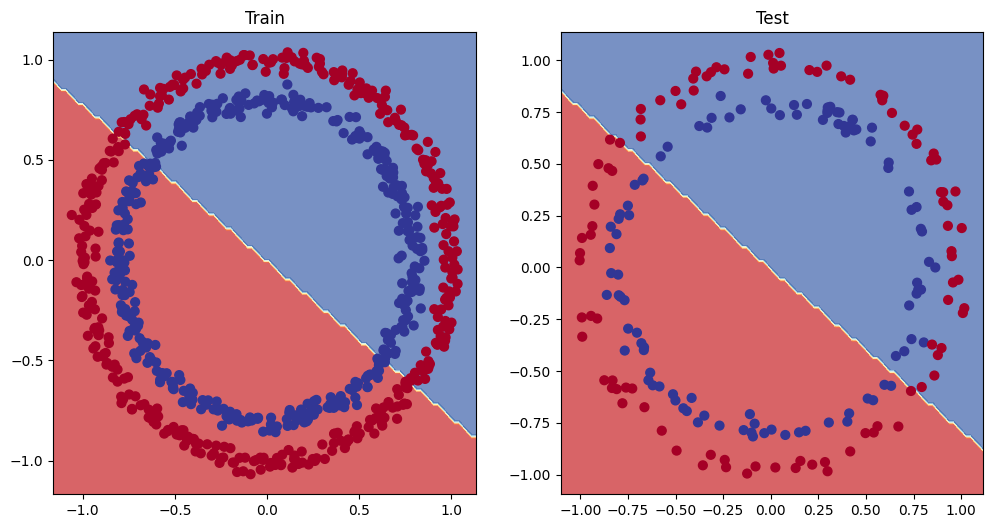

In [29]:
import numpy as np

# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from the model's perspective)

* Add more layers - give the model more chances to learn about data and patterns
* Add more hidden units (eg. go from 5 hidden units to 10 hidden units)
* Fit for longer
* Changing the activation function
* Change the learning rate
* Change the loss function

These changes are from the model's perspective because they directly deal with the model rather than the data

Because these options are values that we (as machine learning engineers or data scientists) can change, they are referred to as **hyperparameters**

Let's try to improve our model by:
* Adding more hidden units
* Adding more layers
* Increasing epoch

In [30]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [44]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [32]:
# Training and testing loop
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Send the data to mps
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train()
    
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate the loss/accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss() expects raw logits as inputs
    acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Back propagation
    loss.backward()

    # 5. Gradient descent
    optimizer.step()

    ### Testing
    model_1.eval()

    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate the test loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss:.5f} | Train accuracy: {acc:.2f}% | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")

Epoch: 0 | Train loss: 0.69396 | Train accuracy: 50.88% | Test loss: 0.69261 | Test accuracy: 51.00%
Epoch: 100 | Train loss: 0.69395 | Train accuracy: 50.88% | Test loss: 0.69261 | Test accuracy: 51.00%
Epoch: 200 | Train loss: 0.69395 | Train accuracy: 50.75% | Test loss: 0.69261 | Test accuracy: 51.00%
Epoch: 300 | Train loss: 0.69394 | Train accuracy: 50.75% | Test loss: 0.69261 | Test accuracy: 51.00%
Epoch: 400 | Train loss: 0.69394 | Train accuracy: 50.75% | Test loss: 0.69261 | Test accuracy: 51.00%
Epoch: 500 | Train loss: 0.69394 | Train accuracy: 50.75% | Test loss: 0.69261 | Test accuracy: 51.00%
Epoch: 600 | Train loss: 0.69394 | Train accuracy: 50.75% | Test loss: 0.69261 | Test accuracy: 51.00%
Epoch: 700 | Train loss: 0.69393 | Train accuracy: 50.75% | Test loss: 0.69261 | Test accuracy: 51.00%
Epoch: 800 | Train loss: 0.69393 | Train accuracy: 50.62% | Test loss: 0.69261 | Test accuracy: 51.00%
Epoch: 900 | Train loss: 0.69393 | Train accuracy: 50.62% | Test loss: 0.69

## 6. The missing piece: non-linearity

"What patterns can you draw if you are given an infinite number of linear and non-linear lines"

### 6.1 Recreating non-linear data (red and blue circles)

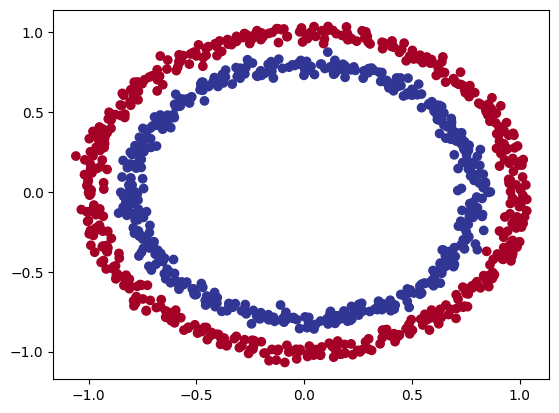

In [38]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [40]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

Artificial neural networks are a large combination of linear and non-linear functions which are potentially able to find the patterns in the data

In [41]:
# Build a model with non-linear functions
from torch import nn

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Where should we put our non-linear activation function?
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [52]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.01)

### 6.3 Training a non-linear model

In [53]:
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_3.train()
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_pred=y_pred, y_true=y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_pred=test_pred, y_true=y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Train Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%")
        

Epoch: 0 | Train Loss: 0.01011 | Train Accuracy: 100.00% | Test Loss: 0.02390 | Test Accuracy: 99.50%
Epoch: 100 | Train Loss: 0.01007 | Train Accuracy: 100.00% | Test Loss: 0.02384 | Test Accuracy: 99.50%
Epoch: 200 | Train Loss: 0.01003 | Train Accuracy: 100.00% | Test Loss: 0.02378 | Test Accuracy: 99.50%
Epoch: 300 | Train Loss: 0.01000 | Train Accuracy: 100.00% | Test Loss: 0.02372 | Test Accuracy: 99.50%
Epoch: 400 | Train Loss: 0.00996 | Train Accuracy: 100.00% | Test Loss: 0.02366 | Test Accuracy: 99.50%
Epoch: 500 | Train Loss: 0.00993 | Train Accuracy: 100.00% | Test Loss: 0.02360 | Test Accuracy: 99.50%
Epoch: 600 | Train Loss: 0.00989 | Train Accuracy: 100.00% | Test Loss: 0.02355 | Test Accuracy: 99.50%
Epoch: 700 | Train Loss: 0.00986 | Train Accuracy: 100.00% | Test Loss: 0.02349 | Test Accuracy: 99.50%
Epoch: 800 | Train Loss: 0.00983 | Train Accuracy: 100.00% | Test Loss: 0.02343 | Test Accuracy: 99.50%
Epoch: 900 | Train Loss: 0.00979 | Train Accuracy: 100.00% | Test 